In [1]:
import torch
import matplotlib.pyplot as plt
import utils
import dataloaders
import numpy as np
import torchvision
import os
from trainer import Trainer
from torchsummary import summary
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cuda.deterministic = True

### Model Definition

In [2]:
def conv_block(in_features, out_features, conv_kernel_size, conv_stride_size, conv_padding_size, mp_kernel_size, mp_stride_size, mp_padding_size):
    return torch.nn.Sequential(
      torch.nn.Conv2d(in_features, out_features, conv_kernel_size, conv_stride_size, conv_padding_size),
      torch.nn.MaxPool2d(mp_kernel_size, mp_stride_size, mp_padding_size),
      torch.nn.ReLU()
  )

class LeNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        conv_F = 5
        conv_S = 1
        conv_P = 2

        maxpool_F = 2
        maxpool_S = 2
        maxpool_P = 0

        num_input_nodes = 32*32
        num_hidden_nodes = 64
        num_classes = 10
        
        self.encoding = torch.nn.Sequential(
            conv_block(1, 32,
                       conv_F, conv_S, conv_P,
                       maxpool_F, maxpool_S, maxpool_P),
            conv_block(32, 64,
                       conv_F, conv_S, conv_P,
                       maxpool_F, maxpool_S, maxpool_P),
            conv_block(64, 128,
                       conv_F, conv_S, conv_P,
                       maxpool_F, maxpool_S, maxpool_P)
        )

        self.decoding = torch.nn.Sequential(
            torch.nn.Flatten(1),
            torch.nn.Linear(4*4*128, num_hidden_nodes),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hidden_nodes, num_classes)
        )

         

    def forward(self, x):
        x = self.encoding(x)
        #x = x.view(-1, 32*32) # flatten
        x = self.decoding(x)
        return x


In [ ]:
model_1 = LeNet()
summary(model_1, (1, 32, 32))

### Hyperparameters & Loss function

In [5]:
# Hyperparameters
batch_size = 64
learning_rate = 0.0192
num_epochs = 4


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

### Train model

In [6]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.25])
])
dataloader_train, dataloader_val = dataloaders.load_dataset(batch_size, image_transform)

# Model definition
model = LeNet()
# Transfer model to GPU memory (if possible)
model = utils.to_cuda(model)

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_val=dataloader_val,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, val_loss_dict = trainer.train(num_epochs)

 97%|█████████▋| 9641984/9912422 [00:11<00:00, 1597993.80it/s]
0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]
32768it [00:00, 90125.38it/s]                            

0it [00:00, ?it/s]
 74%|███████▍  | 1220608/1648877 [00:01<00:00, 794550.53it/s]
1654784it [00:01, 1129793.31it/s]                             

0it [00:00, ?it/s]
8192it [00:00, 34761.16it/s]            

Training epoch 0:  21%|██▏       | 200/938 [00:15<00:57, 12.75it/s]
9920512it [00:29, 1597993.80it/s]                             
Training epoch 0: 100%|██████████| 938/938 [01:15<00:00, 12.48it/s]

Training epoch 1: 100%|██████████| 938/938 [01:11<00:00, 13.20it/s]

Training epoch 2: 100%|██████████| 938/938 [01:11<00:00, 13.12it/s]

Training epoch 3: 100%|██████████| 938/938 [01:12<00:00, 12.95it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


### Train Model

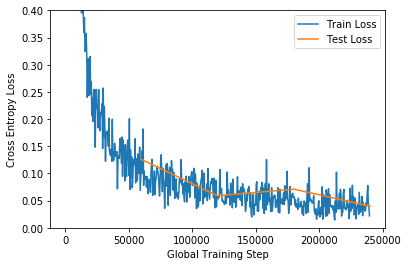

In [7]:
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(val_loss_dict, label="Test Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, .4])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
os.makedirs("image_processed", exist_ok=True)
plt.savefig(os.path.join("image_processed", "task2.png"))

plt.show()

torch.save(model.state_dict(), "saved_model.torch")


In [8]:

# %%
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_val, model, loss_function)
print(f"Final Validation loss: {final_loss}. Final Validation accuracy: {final_acc}")

# %%

Final Validation loss: 0.039861915481260494. Final Validation accuracy: 0.9874
